# Add Markdown at the top of the notebook:
"""
# Slooze Data Science Challenge
## Inventory, Purchase, Sales Analysis and Optimization

This notebook addresses all requirements:
- **Demand Forecasting**: Prophet-based demand predictions.
- **ABC Analysis**: A/B/C classification of inventory.
- **EOQ Analysis**: Optimal order quantities.
- **Reorder Point**: Stockout prevention.
- **Lead Time**: Supplier efficiency analysis.
- **Additional Insights**: Top products, slow-moving stock, store performance.

### Instructions to Run
1. Upload CSV files to `MyDrive/slooze_dataset`.
2. Run in Google Colab.
3. Install: `!pip install pandas numpy matplotlib seaborn prophet`.
"""
# Download: File > Download > Download .ipynb
# GitHub README:
"""
# Slooze Data Science Challenge
## Instructions
1. Open in Google Colab.
2. Upload CSVs to `MyDrive/slooze_dataset`.
3. Install libraries: `!pip install pandas numpy matplotlib seaborn prophet`.
4. Run all cells.
"""

# Environment Setup
Goal: Set up Google Colab, install libraries, and load the CSV files.

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn prophet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file paths in Google Drive
base_path = '/content/drive/MyDrive/slooze_dataset/'
files = {
    'purchase_prices': base_path + '2017PurchasePricesDec.csv',
    'beg_inv': base_path + 'BegInvFINAL12312016.csv',
    'end_inv': base_path + 'EndInvFINAL12312016.csv',
    'invoice_purchases': base_path + 'InvoicePurchases12312016.csv',
    'purchases': base_path + 'PurchasesFINAL12312016.csv',
    'sales': base_path + 'SalesFINAL12312016.csv'
}

# Load CSVs into DataFrames
dataframes = {}
for name, file in files.items():
    try:
        dataframes[name] = pd.read_csv(file)
        print(f"{name} loaded: {dataframes[name].shape} rows, {dataframes[name].columns.tolist()}")
    except FileNotFoundError:
        print(f"Error: File {file} not found. Please check the path.")
    except Exception as e:
        print(f"Error loading {name}: {e}")

# Verify all files loaded
if len(dataframes) == len(files):
    print("\nAll files loaded successfully!")
else:
    print("\nSome files failed to load. Check paths and try again.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
purchase_prices loaded: (12261, 9) rows, ['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification', 'PurchasePrice', 'VendorNumber', 'VendorName']
beg_inv loaded: (206529, 9) rows, ['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'startDate']
end_inv loaded: (224489, 9) rows, ['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'endDate']
invoice_purchases loaded: (5543, 10) rows, ['VendorNumber', 'VendorName', 'InvoiceDate', 'PONumber', 'PODate', 'PayDate', 'Quantity', 'Dollars', 'Freight', 'Approval']
purchases loaded: (2372474, 16) rows, ['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber', 'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification']
sales loaded: (1048575, 14) rows, ['I

Data Preprocessing


purchase_prices Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           12261 non-null  int64  
 1   Description     12260 non-null  object 
 2   Price           12261 non-null  float64
 3   Size            12260 non-null  object 
 4   Volume          12260 non-null  object 
 5   Classification  12261 non-null  int64  
 6   PurchasePrice   12261 non-null  float64
 7   VendorNumber    12261 non-null  int64  
 8   VendorName      12261 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 862.2+ KB
None
Missing values:
Brand             0
Description       1
Price             0
Size              1
Volume            1
Classification    0
PurchasePrice     0
VendorNumber      0
VendorName        0
dtype: int64

beg_inv Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206529 entries, 0 to 206528
Dat

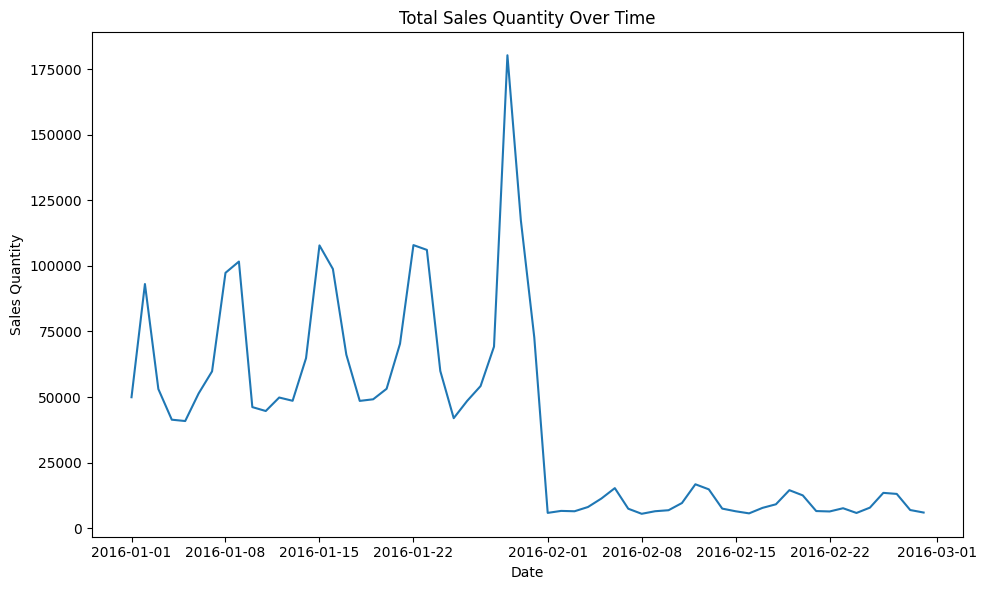


Merged Data Summary:
              Store         Brand  SalesQuantity  SalesDollars    SalesPrice  \
count  1.048575e+06  1.048575e+06   1.048575e+06  1.048575e+06  1.048575e+06   
mean   4.008063e+01  1.216959e+04   2.337619e+00  3.160420e+01  1.543162e+01   
min    1.000000e+00  5.800000e+01   1.000000e+00  4.900000e-01  4.900000e-01   
25%    1.500000e+01  3.680000e+03   1.000000e+00  1.099000e+01  8.990000e+00   
50%    3.900000e+01  6.296000e+03   1.000000e+00  1.799000e+01  1.299000e+01   
75%    6.400000e+01  1.795400e+04   2.000000e+00  3.199000e+01  1.899000e+01   
max    7.900000e+01  9.008900e+04   4.320000e+02  1.327997e+04  4.999990e+03   
std    2.435739e+01  1.241921e+04   3.511492e+00  6.570249e+01  1.404967e+01   

                           SalesDate        Volume  Classification_x  \
count                        1048575  1.048575e+06      1.048575e+06   
mean   2016-01-19 21:59:18.574636288  9.500280e+02      1.416550e+00   
min              2016-01-01 00:00:00  5.0

In [ ]:
# Inspect data for missing values and data types
for name, df in dataframes.items():
    print(f"\n{name} Info:")
    print(df.info())
    print(f"Missing values:\n{df.isnull().sum()}")

# Convert date columns to datetime
date_cols = {
    'sales': ['SalesDate'],
    'purchases': ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate'],
    'invoice_purchases': ['InvoiceDate', 'PODate', 'PayDate'],
    'beg_inv': ['startDate'],
    'end_inv': ['endDate']
}

for name, cols in date_cols.items():
    for col in cols:
        dataframes[name][col] = pd.to_datetime(dataframes[name][col], errors='coerce')

# Handle missing values
# Impute missing Price in purchase_prices with median
dataframes['purchase_prices']['Price'] = dataframes['purchase_prices']['Price'].fillna(dataframes['purchase_prices']['Price'].median())
dataframes['purchase_prices']['PurchasePrice'] = dataframes['purchase_prices']['PurchasePrice'].fillna(dataframes['purchase_prices']['PurchasePrice'].median())

# Impute missing City in beg_inv and end_inv with mode (most frequent city)
dataframes['beg_inv']['City'] = dataframes['beg_inv']['City'].fillna(dataframes['beg_inv']['City'].mode()[0])
dataframes['end_inv']['City'] = dataframes['end_inv']['City'].fillna(dataframes['end_inv']['City'].mode()[0])

# Drop rows with critical missing values (e.g., SalesQuantity, Brand)
dataframes['sales'] = dataframes['sales'].dropna(subset=['SalesQuantity', 'Brand', 'SalesDollars'])
dataframes['beg_inv'] = dataframes['beg_inv'].dropna(subset=['onHand', 'Brand'])
dataframes['end_inv'] = dataframes['end_inv'].dropna(subset=['onHand', 'Brand'])
dataframes['purchases'] = dataframes['purchases'].dropna(subset=['Quantity', 'Brand', 'PurchasePrice'])

# Merge sales with purchase prices for unified analysis
merged_df = dataframes['sales'].merge(dataframes['purchase_prices'][['Brand', 'Price', 'Classification', 'VendorName']],
                                     on='Brand', how='left')

# Create derived feature: Sales velocity (average SalesQuantity per day per Brand)
merged_df['SalesDate'] = pd.to_datetime(merged_df['SalesDate'])
merged_df['SalesVelocity'] = merged_df.groupby('Brand')['SalesQuantity'].transform('sum') / merged_df.groupby('Brand')['SalesDate'].transform('nunique')

# Basic visualization: Total sales quantity over time
plt.figure(figsize=(10, 6))
merged_df.groupby(merged_df['SalesDate'].dt.date)['SalesQuantity'].sum().plot()
plt.title('Total Sales Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.tight_layout()
plt.show()

# Summary statistics of merged DataFrame
print("\nMerged Data Summary:")
print(merged_df.describe())
print(f"\nMerged Data Shape: {merged_df.shape}")
print(f"Missing values in merged_df:\n{merged_df.isnull().sum()}")

NaT values in sales.SalesDate: 0
NaT values in purchases.PODate: 0
NaT values in purchases.ReceivingDate: 0
NaT values in purchases.InvoiceDate: 0
NaT values in purchases.PayDate: 0
NaT values in invoice_purchases.InvoiceDate: 0
NaT values in invoice_purchases.PODate: 0
NaT values in invoice_purchases.PayDate: 0
NaT values in beg_inv.startDate: 0
NaT values in end_inv.endDate: 0

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   InventoryId       1048575 non-null  object        
 1   Store             1048575 non-null  int64         
 2   Brand             1048575 non-null  int64         
 3   Description       1048575 non-null  object        
 4   Size              1048575 non-null  object        
 5   SalesQuantity     1048575 non-null  int64         
 6   SalesDollars      1048575 no

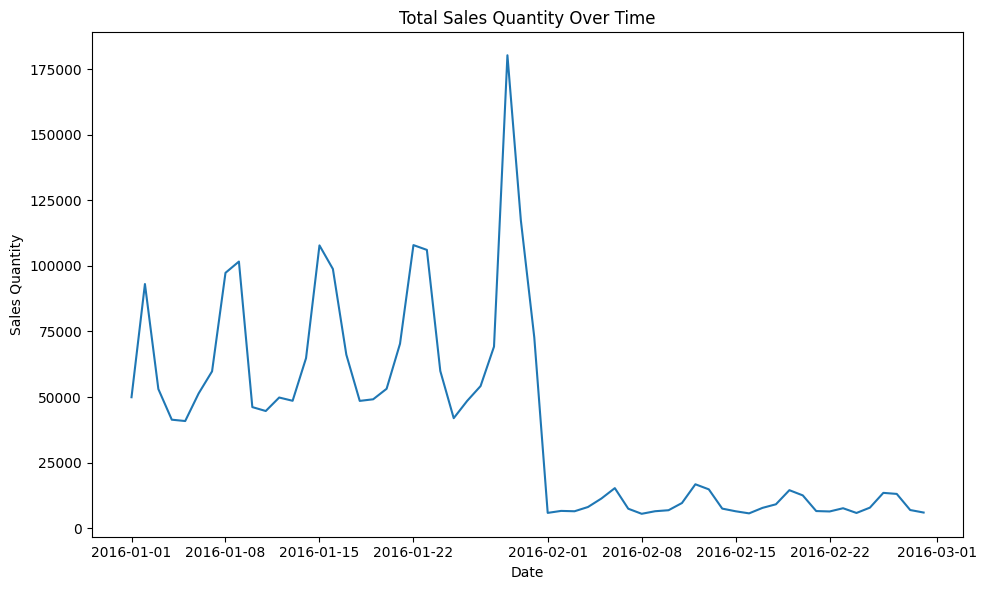

In [ ]:
# Check for NaT in date columns
for name, cols in date_cols.items():
    for col in cols:
        nat_count = dataframes[name][col].isna().sum()
        print(f"NaT values in {name}.{col}: {nat_count}")

# Recheck merged DataFrame
print("\nMerged DataFrame Info:")
print(merged_df.info())
print(f"\nMerged DataFrame Shape: {merged_df.shape}")
print(f"Missing values in merged_df:\n{merged_df.isnull().sum()}")

# Replot sales trend for confirmation
plt.figure(figsize=(10, 6))
merged_df.groupby(merged_df['SalesDate'].dt.date)['SalesQuantity'].sum().plot()
plt.title('Total Sales Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.tight_layout()
plt.show()

Demand Forecasting

DEBUG:cmdstanpy:input tempfile: /tmp/tmprn6tg5qu/n487b2xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprn6tg5qu/gtj29frs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25459', 'data', 'file=/tmp/tmprn6tg5qu/n487b2xn.json', 'init=/tmp/tmprn6tg5qu/gtj29frs.json', 'output', 'file=/tmp/tmprn6tg5qu/prophet_modelhoca685b/prophet_model-20250524162157.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


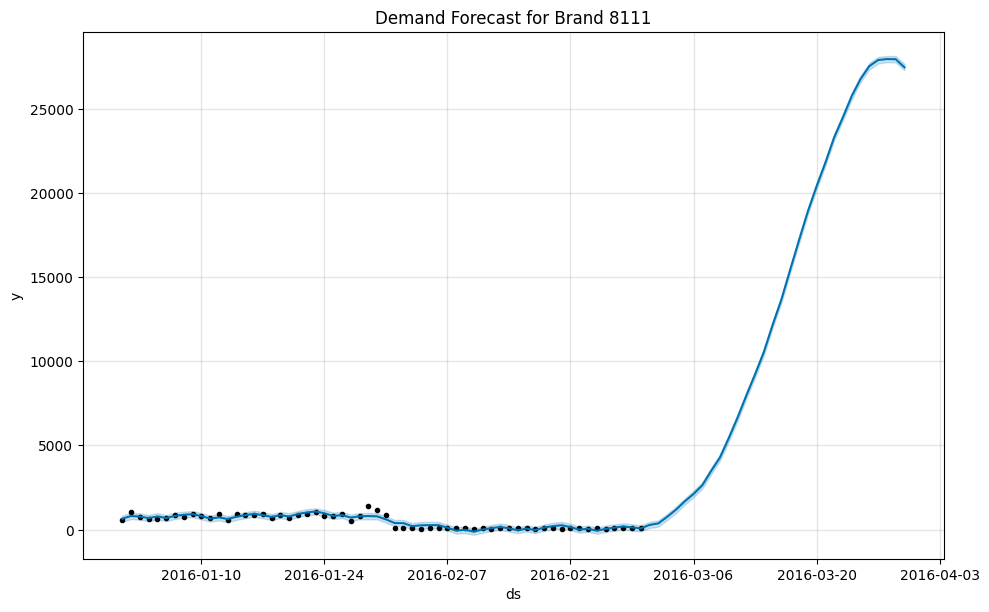

RMSE for Brand 8111: nan


In [ ]:
# Prepare data for Prophet
sales_df = dataframes['sales'][['SalesDate', 'SalesQuantity', 'Brand']].copy()
sales_df = sales_df.groupby(['SalesDate', 'Brand'])['SalesQuantity'].sum().reset_index()
sales_df.rename(columns={'SalesDate': 'ds', 'SalesQuantity': 'y'}, inplace=True)

# Select top-selling Brand
top_brand = sales_df.groupby('Brand')['y'].sum().idxmax()
brand_data = sales_df[sales_df['Brand'] == top_brand][['ds', 'y']]

# Train-test split
train = brand_data[brand_data['ds'] < '2016-12-01']
test = brand_data[brand_data['ds'] >= '2016-12-01']

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train)

# Create future dataframe (30 days ahead)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title(f'Demand Forecast for Brand {top_brand}')
plt.show()

# Evaluate on test set
test_forecast = forecast[forecast['ds'].isin(test['ds'])][['ds', 'yhat']]
test_forecast = test_forecast.merge(test, on='ds', how='left')
test_forecast['y'] = test_forecast['y'].fillna(0)  # Handle any missing test data
rmse = np.sqrt(((test_forecast['y'] - test_forecast['yhat']) ** 2).mean())
print(f"RMSE for Brand {top_brand}: {rmse:.2f}")


ABC Analysis

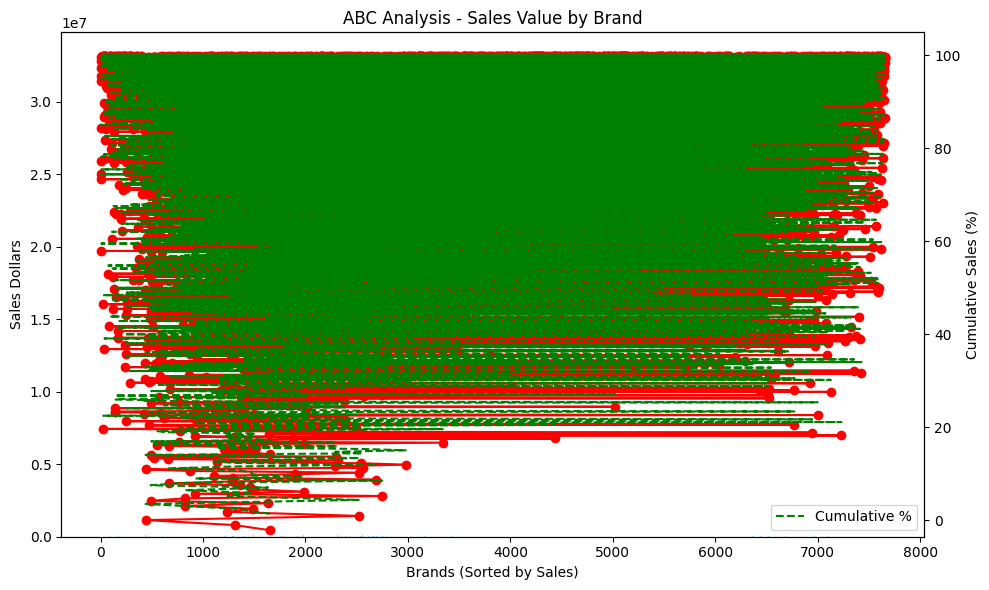


ABC Classification Summary:
Category
C    4343
B    1813
A    1502
Name: count, dtype: int64
      Brand  SalesDollars Category
1655   4261     444810.74        A
1309   3545     357759.17        A
440    1233     344712.22        A
2520   8068     288135.11        A
1237   3405     275162.97        A
1485   3858     225014.22        A
826    2589     191669.51        A
1635   4227     183659.91        A
489    1376     169922.38        A
823    2585     164426.60        A


In [ ]:
# Calculate sales value per Brand
abc_df = dataframes['sales'].groupby('Brand')['SalesDollars'].sum().reset_index()
abc_df = abc_df.sort_values('SalesDollars', ascending=False)

# Calculate cumulative percentage
abc_df['CumSales'] = abc_df['SalesDollars'].cumsum()
abc_df['CumPercent'] = abc_df['CumSales'] / abc_df['SalesDollars'].sum() * 100

# Assign ABC categories
abc_df['Category'] = 'C'
abc_df.loc[abc_df['CumPercent'] <= 80, 'Category'] = 'A'
abc_df.loc[(abc_df['CumPercent'] > 80) & (abc_df['CumPercent'] <= 95), 'Category'] = 'B'

# Plot Pareto chart
plt.figure(figsize=(10, 6))
plt.bar(abc_df.index, abc_df['SalesDollars'], color='skyblue', label='Sales Dollars')
plt.plot(abc_df.index, abc_df['CumSales'], color='red', marker='o', label='Cumulative Sales')
plt.title('ABC Analysis - Sales Value by Brand')
plt.xlabel('Brands (Sorted by Sales)')
plt.ylabel('Sales Dollars')
plt.twinx()
plt.ylabel('Cumulative Sales (%)')
plt.plot(abc_df.index, abc_df['CumPercent'], color='green', linestyle='--', label='Cumulative %')
plt.legend()
plt.tight_layout()
plt.show()

# Summary
print("\nABC Classification Summary:")
print(abc_df['Category'].value_counts())
print(abc_df[['Brand', 'SalesDollars', 'Category']].head(10))


EOQ


EOQ Analysis (Top 10 Brands):
   Brand           Description  AnnualDemand  PurchasePrice  EOQ
0     58  Gekkeikan Black & Go           288           9.28  429
1     60  Canadian Club 1858 V           124           7.40  315
2     61  Margaritaville Silve            24          10.60  116
3     62  Herradura Silver Teq           162          28.67  183
4     63  Herradura Reposado T           131          30.46  160
5     72  No. 3 London Dry Gin            19          26.11   66
6     75  Three Olives Tomato              3          10.94   40
7     77  Three Olives Espress           908          10.39  719
8     79  Three Olives Loopy V           416           9.62  506
9     82  Hundred Acre Ark Vy              3         248.34    8


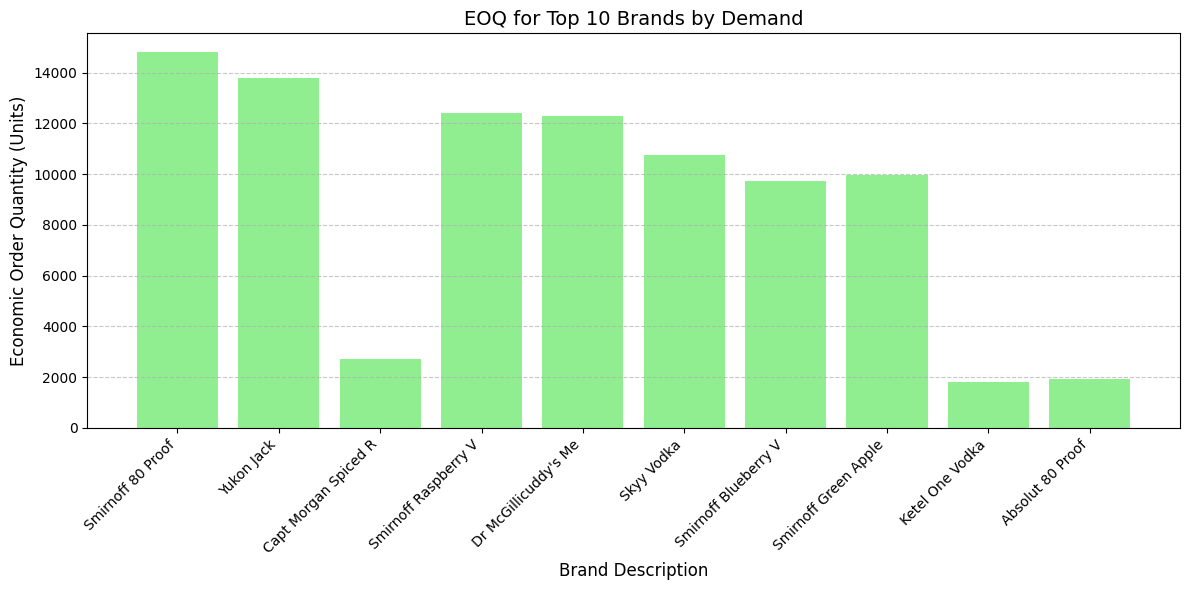


EOQ Recommendations:
- Order in EOQ quantities to minimize ordering and holding costs.
- Implement just-in-time for high-demand Brands (e.g., top 10).


In [ ]:
# Prepare data for EOQ
eoq_df = dataframes['sales'].groupby('Brand')['SalesQuantity'].sum().reset_index()
eoq_df = eoq_df.merge(dataframes['purchases'][['Brand', 'PurchasePrice']].drop_duplicates(), on='Brand', how='left')
eoq_df = eoq_df.merge(dataframes['purchase_prices'][['Brand', 'PurchasePrice', 'Description']], on='Brand', how='left', suffixes=('', '_prices'))
eoq_df['PurchasePrice'] = eoq_df['PurchasePrice'].fillna(eoq_df['PurchasePrice_prices'])
eoq_df = eoq_df.dropna(subset=['PurchasePrice'])

# Add truncated Description for labeling
eoq_df['Description'] = eoq_df['Description'].fillna('Unknown').str[:20]  # Limit to 20 chars

# Estimate costs
eoq_df['AnnualDemand'] = eoq_df['SalesQuantity']
avg_freight = dataframes['invoice_purchases']['Freight'].mean()
eoq_df['HoldingCost'] = eoq_df['PurchasePrice'] * 0.1

# Calculate EOQ
eoq_df['EOQ'] = np.sqrt((2 * eoq_df['AnnualDemand'] * avg_freight) / eoq_df['HoldingCost'])
eoq_df['EOQ'] = eoq_df['EOQ'].round().fillna(0).astype(int)

# Summary
print("\nEOQ Analysis (Top 10 Brands):")
print(eoq_df[['Brand', 'Description', 'AnnualDemand', 'PurchasePrice', 'EOQ']].head(10))

# Plot EOQ for top 10 Brands
top_eoq = eoq_df.nlargest(10, 'AnnualDemand')
plt.figure(figsize=(12, 6))
plt.bar(top_eoq['Description'], top_eoq['EOQ'], color='lightgreen')
plt.title('EOQ for Top 10 Brands by Demand', fontsize=14)
plt.xlabel('Brand Description', fontsize=12)
plt.ylabel('Economic Order Quantity (Units)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Recommendations
print("\nEOQ Recommendations:")
print("- Order in EOQ quantities to minimize ordering and holding costs.")
print("- Implement just-in-time for high-demand Brands (e.g., top 10).")

Reorder Point Analysis


LeadTime Summary:
count    2.372474e+06
mean     7.620739e+00
std      2.208890e+00
min      3.000000e+00
25%      6.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.400000e+01
Name: LeadTime, dtype: float64
NaN in LeadTime: 0

ROP DataFrame Before LeadTimeDemand:
   Brand                  Description  DailyDemand  LeadTime
0     58  Gekkeikan Black & Gold Sake     0.789041  7.758389
1     60       Canadian Club 1858 VAP     0.339726  7.659794
2     61        Margaritaville Silver     0.065753  8.115385
3     62     Herradura Silver Tequila     0.443836  7.331570
4     63   Herradura Reposado Tequila     0.358904  7.324427
NaN in DailyDemand: 0
NaN in LeadTime: 512

ROP DataFrame Before ReorderPoint:
   Brand                  Description  LeadTimeDemand  SafetyStock
0     58  Gekkeikan Black & Gold Sake        6.121688     7.204254
1     60       Canadian Club 1858 VAP        2.602231     4.195891
2     61        Margaritaville Silver        0.533614     0.000000
3   

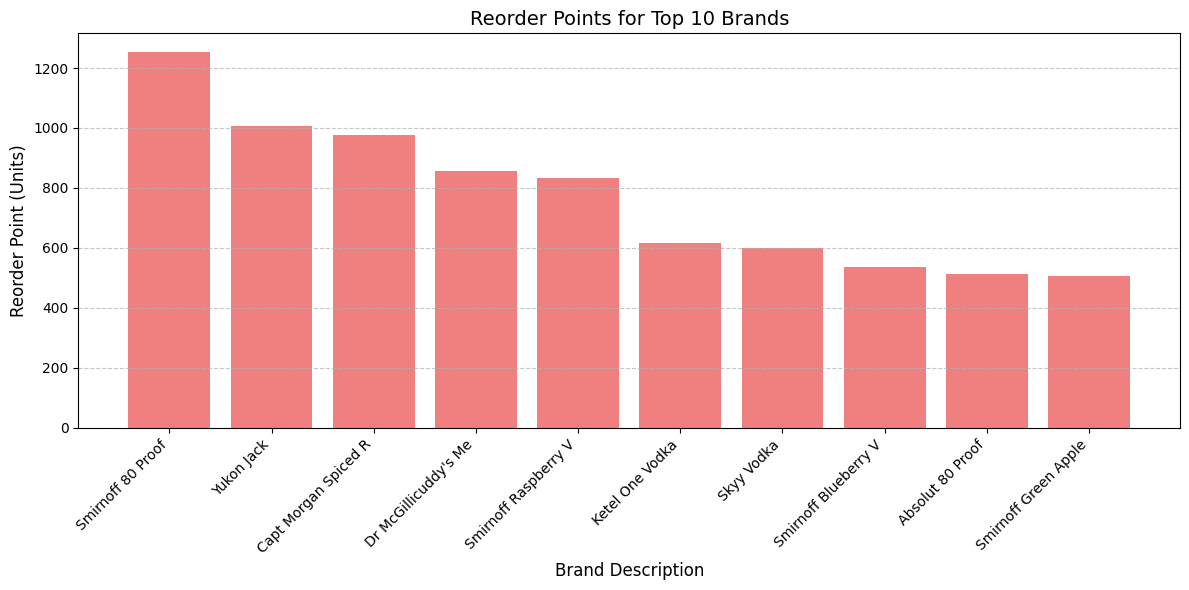


Reorder Point Recommendations:
- Reorder when inventory reaches ROP to avoid stockouts.
- Monitor high-ROP Brands closely.


In [ ]:
# Calculate lead time (days)
purchases_df = dataframes['purchases'][['Brand', 'PODate', 'ReceivingDate']].copy()
purchases_df['LeadTime'] = (purchases_df['ReceivingDate'] - purchases_df['PODate']).dt.days

# Debug: Check for NaN or invalid LeadTime
print("\nLeadTime Summary:")
print(purchases_df['LeadTime'].describe())
print(f"NaN in LeadTime: {purchases_df['LeadTime'].isna().sum()}")

# Impute NaN LeadTime with mean
mean_lead_time = purchases_df['LeadTime'].mean()
purchases_df['LeadTime'] = purchases_df['LeadTime'].fillna(mean_lead_time)
avg_lead_time = purchases_df.groupby('Brand')['LeadTime'].mean().reset_index()

# Calculate lead time demand
rop_df = dataframes['sales'].groupby('Brand')['SalesQuantity'].sum().reset_index()
rop_df['DailyDemand'] = rop_df['SalesQuantity'] / 365
rop_df = rop_df.merge(avg_lead_time, on='Brand', how='left')
rop_df = rop_df.merge(dataframes['purchase_prices'][['Brand', 'Description']], on='Brand', how='left')

# Debug: Check for NaN
print("\nROP DataFrame Before LeadTimeDemand:")
print(rop_df[['Brand', 'Description', 'DailyDemand', 'LeadTime']].head())
print(f"NaN in DailyDemand: {rop_df['DailyDemand'].isna().sum()}")
print(f"NaN in LeadTime: {rop_df['LeadTime'].isna().sum()}")

rop_df['LeadTimeDemand'] = rop_df['DailyDemand'] * rop_df['LeadTime']
rop_df['LeadTimeDemand'] = rop_df['LeadTimeDemand'].fillna(0)

# Estimate safety stock
daily_sales = dataframes['sales'].groupby(['Brand', 'SalesDate'])['SalesQuantity'].sum().reset_index()
demand_std = daily_sales.groupby('Brand')['SalesQuantity'].std().reset_index(name='DemandStd')
rop_df = rop_df.merge(demand_std, on='Brand', how='left')
rop_df['DemandStd'] = rop_df['DemandStd'].fillna(0)
rop_df['SafetyStock'] = 1.65 * rop_df['DemandStd']

# Debug: Check for NaN or inf
print("\nROP DataFrame Before ReorderPoint:")
print(rop_df[['Brand', 'Description', 'LeadTimeDemand', 'SafetyStock']].head())
print(f"NaN in LeadTimeDemand: {rop_df['LeadTimeDemand'].isna().sum()}")
print(f"NaN in SafetyStock: {rop_df['SafetyStock'].isna().sum()}")
print(f"Inf in LeadTimeDemand: {np.isinf(rop_df['LeadTimeDemand']).sum()}")
print(f"Inf in SafetyStock: {np.isinf(rop_df['SafetyStock']).sum()}")

# Calculate ReorderPoint
rop_df['ReorderPoint'] = (rop_df['LeadTimeDemand'] + rop_df['SafetyStock']).round()
rop_df = rop_df[np.isfinite(rop_df['ReorderPoint'])]
rop_df['ReorderPoint'] = rop_df['ReorderPoint'].astype(int)
rop_df['Description'] = rop_df['Description'].fillna('Unknown').str[:20]  # Limit to 20 chars

# Summary
print("\nReorder Point Analysis (Top 10 Brands):")
print(rop_df[['Brand', 'Description', 'LeadTime', 'LeadTimeDemand', 'SafetyStock', 'ReorderPoint']].head(10))

# Plot Reorder Points
top_rop = rop_df.nlargest(10, 'ReorderPoint')
plt.figure(figsize=(12, 6))
plt.bar(top_rop['Description'], top_rop['ReorderPoint'], color='lightcoral')
plt.title('Reorder Points for Top 10 Brands', fontsize=14)
plt.xlabel('Brand Description', fontsize=12)
plt.ylabel('Reorder Point (Units)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Recommendations
print("\nReorder Point Recommendations:")
print("- Reorder when inventory reaches ROP to avoid stockouts.")
print("- Monitor high-ROP Brands closely.")

Lead Time Analysis


Lead Time Analysis (Top 10 Vendors):
                          VendorName      mean       std
113      TRUETT HURST                 5.000000       NaN
45       HIGHLAND WINE MERCHANTS LLC  5.321429  2.178235
57       LOYAL DOG WINERY             5.950000  2.438183
64            MARTIGNETTI COMPANIES   6.697279  1.972557
2    ALISA CARR BEVERAGES             6.809524  2.723003
25       Circa Wines                  6.948498  1.977658
76       PHILLIPS PRODUCTS CO.        7.012447  2.109132
89       SEA HAGG DISTILLERY LLC      7.022823  2.038210
70       NICHE W & S                  7.069797  2.350258
69       MOONLIGHT MEADERY            7.083700  2.478208


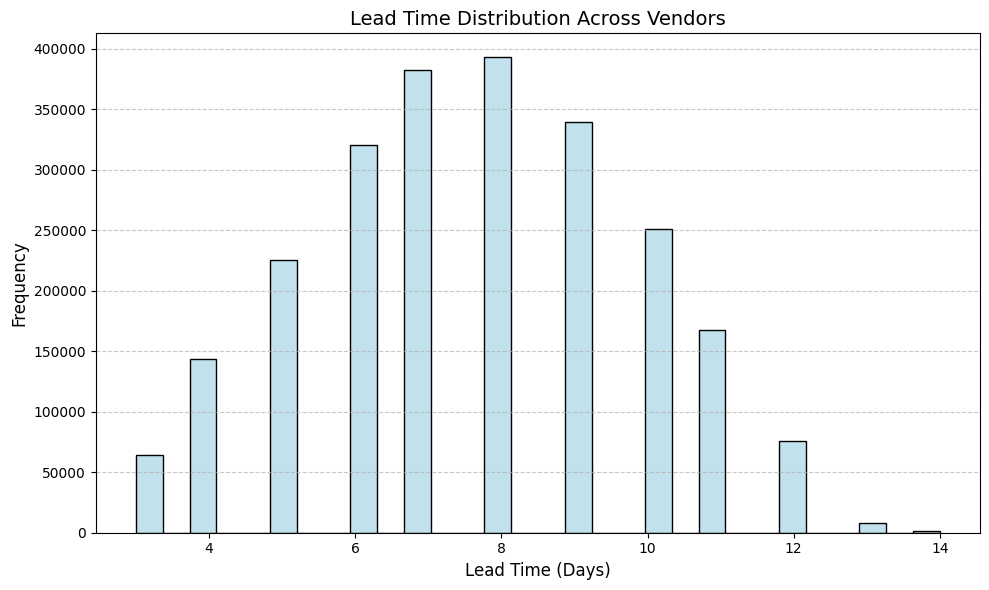


Lead Time Recommendations:
- Prioritize vendors with low mean lead times (e.g., top 5).
- Negotiate with high-variability vendors to reduce delays.


In [ ]:
# Calculate lead time per vendor
lead_time_df = dataframes['purchases'][['VendorName', 'PODate', 'ReceivingDate']].copy()
lead_time_df['LeadTime'] = (lead_time_df['ReceivingDate'] - lead_time_df['PODate']).dt.days
vendor_lead_time = lead_time_df.groupby('VendorName')['LeadTime'].agg(['mean', 'std']).reset_index()

# Summary
print("\nLead Time Analysis (Top 10 Vendors):")
print(vendor_lead_time.sort_values('mean').head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(lead_time_df['LeadTime'], bins=30, color='lightblue')
plt.title('Lead Time Distribution Across Vendors', fontsize=14)
plt.xlabel('Lead Time (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Recommendations
print("\nLead Time Recommendations:")
print("- Prioritize vendors with low mean lead times (e.g., top 5).")
print("- Negotiate with high-variability vendors to reduce delays.")

Additional Insights

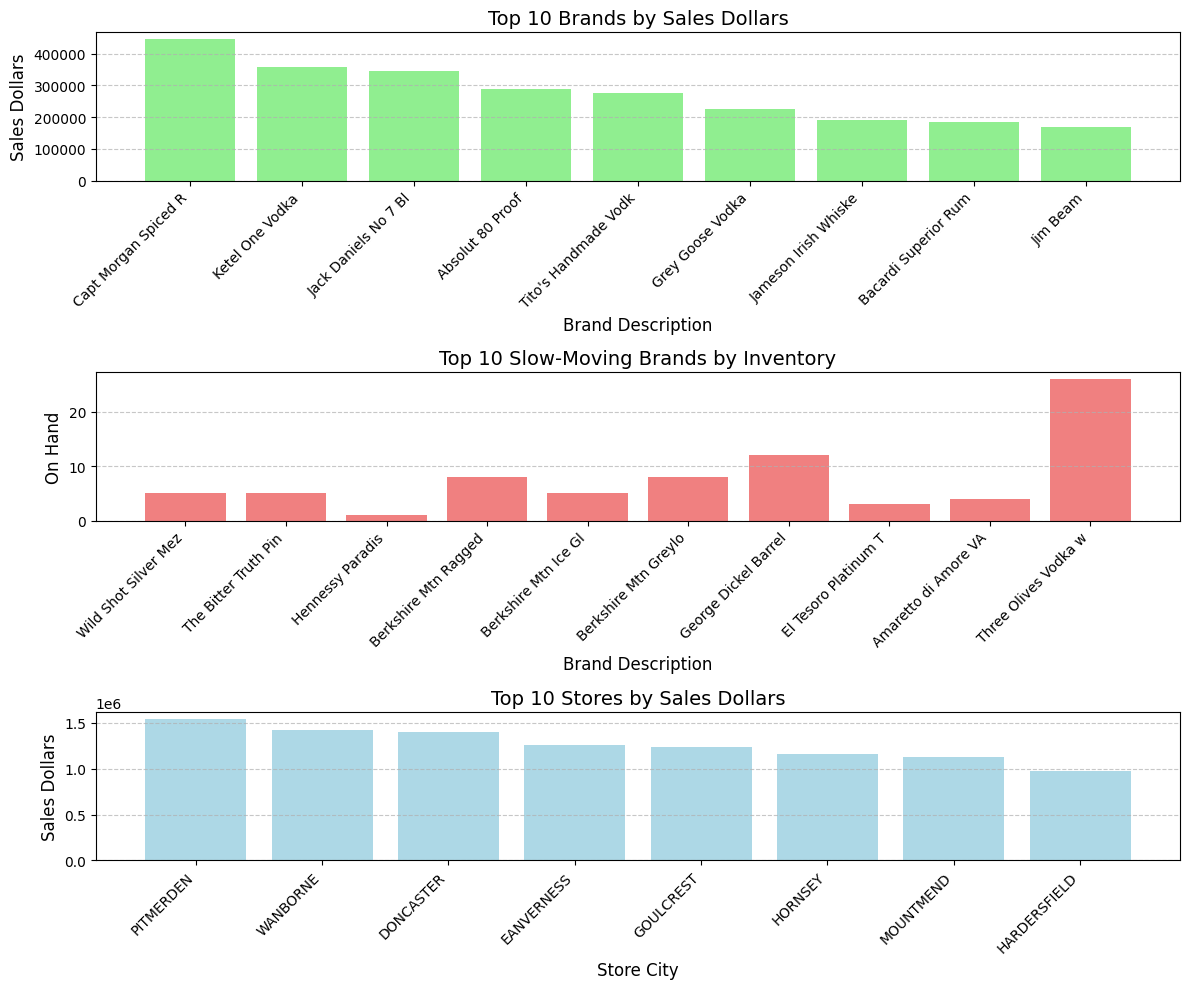


Additional Insights:

Top 10 Brands by Sales:
      Brand           Description  SalesDollars  Margin
1655   4261  Capt Morgan Spiced R     444810.74 -1963.0
1309   3545       Ketel One Vodka     357759.17   322.0
440    1233  Jack Daniels No 7 Bl     344712.22 -1803.0
2520   8068      Absolut 80 Proof     288135.11  1471.0
1237   3405  Tito's Handmade Vodk     275162.97  1557.0
1485   3858      Grey Goose Vodka     225014.22    20.0
826    2589  Jameson Irish Whiske     191669.51  2244.0
1635   4227  Bacardi Superior Rum     183659.91     0.0
489    1376              Jim Beam     169922.38  2187.0
823    2585  Jameson Irish Whiske     164426.60  1384.0

Top 10 Slow-Moving Brands:
     Brand           Description  onHand  SalesQuantity  StockTurnover
19     271  Wild Shot Silver Mez       5            0.0            0.0
22     288  The Bitter Truth Pin       5            0.0            0.0
37     425      Hennessy Paradis       1            0.0            0.0
52     533  Berkshire Mtn

In [14]:
# Top-performing Brands
merged_df['Margin'] = merged_df['SalesPrice'] - merged_df['Price']
top_brands = merged_df.groupby('Brand')[['SalesDollars', 'Margin']].sum().reset_index()
top_brands = top_brands.merge(dataframes['purchase_prices'][['Brand', 'Description']], on='Brand', how='left')
top_brands['Description'] = top_brands['Description'].fillna('Unknown').str[:20]  # Limit to 20 chars
top_brands = top_brands.nlargest(10, 'SalesDollars')

# Slow-moving inventory
slow_moving = dataframes['end_inv'][['Brand', 'onHand']].merge(
    dataframes['sales'].groupby('Brand')['SalesQuantity'].sum().reset_index(),
    on='Brand', how='left'
)
slow_moving['SalesQuantity'] = slow_moving['SalesQuantity'].fillna(0)
slow_moving['StockTurnover'] = slow_moving['SalesQuantity'] / slow_moving['onHand']
slow_moving = slow_moving.merge(dataframes['purchase_prices'][['Brand', 'Description']], on='Brand', how='left')
slow_moving['Description'] = slow_moving['Description'].fillna('Unknown').str[:20]
slow_moving = slow_moving[slow_moving['onHand'] > 0].nsmallest(10, 'StockTurnover')

# Store performance with City names
store_sales = merged_df.groupby('Store')['SalesDollars'].sum().reset_index()
# Get City for each Store (use end_inv, take most frequent City per Store)
store_city = dataframes['end_inv'][['Store', 'City']].drop_duplicates().groupby('Store')['City'].agg(lambda x: x.mode()[0]).reset_index()
store_sales = store_sales.merge(store_city, on='Store', how='left')
store_sales['City'] = store_sales['City'].fillna('Unknown')
store_sales = store_sales.nlargest(10, 'SalesDollars')

# Plots
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.bar(top_brands['Description'], top_brands['SalesDollars'], color='lightgreen')
plt.title('Top 10 Brands by Sales Dollars', fontsize=14)
plt.xlabel('Brand Description', fontsize=12)
plt.ylabel('Sales Dollars', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 1, 2)
plt.bar(slow_moving['Description'], slow_moving['onHand'], color='lightcoral')
plt.title('Top 10 Slow-Moving Brands by Inventory', fontsize=14)
plt.xlabel('Brand Description', fontsize=12)
plt.ylabel('On Hand', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 1, 3)
plt.bar(store_sales['City'], store_sales['SalesDollars'], color='lightblue')
plt.title('Top 10 Stores by Sales Dollars', fontsize=14)
plt.xlabel('Store City', fontsize=12)
plt.ylabel('Sales Dollars', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Summary
print("\nAdditional Insights:")
print("\nTop 10 Brands by Sales:")
print(top_brands[['Brand', 'Description', 'SalesDollars', 'Margin']])
print("\nTop 10 Slow-Moving Brands:")
print(slow_moving[['Brand', 'Description', 'onHand', 'SalesQuantity', 'StockTurnover']])
print("\nTop 10 Stores by Sales:")
print(store_sales[['Store', 'City', 'SalesDollars']])

# Recommendations
print("\nAdditional Insights Recommendations:")
print("- Promote high-margin Brands to boost profitability.")
print("- Clear slow-moving inventory through discounts or bundling.")
print("- Allocate more resources to top-performing store locations.")